# Vorbereitung

In [1]:
%env KERAS_BACKEND=theano
%env THEANO_FLAGS=floatX=float32,device=cpu

env: KERAS_BACKEND=theano
env: THEANO_FLAGS=floatX=float32,device=cpu


In [2]:
%load_ext autoreload
%autoreload 1
%aimport bb_behavior
%aimport bb_behavior.plot
%aimport bb_behavior.tracking
%aimport bb_behavior.tracking.pipeline

import bb_behavior
import bb_behavior.plot
import bb_behavior.tracking
import bb_behavior.tracking.pipeline

Using Theano backend.


# Preprocessing

## Preprocessing step 1: convert the h264 to mp4

## Run

In [3]:
from bb_behavior.tracking.pipeline import get_default_pipeline
default_pipeline = None
default_pipeline = get_default_pipeline(localizer_threshold="0.50")

/Users/ronnyruhe/.local/lib/python3.7/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/Users/ronnyruhe/.local/lib/python3.7/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/Users/ronnyruhe/.local/lib/python3.7/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [4]:
from tqdm import tqdm_notebook # progress bar

import math
import numpy as np
from bb_tracking.data.constants import DETKEY
#from bb_tracking.tracking import score_id_sim_v
from bb_tracking.tracking import distance_orientations_v, distance_positions_v

from bb_behavior.tracking.pipeline import detect_markers_in_video
from bb_behavior.tracking.pipeline import track_detections_dataframe
from bb_behavior.tracking.pipeline import display_tracking_results

In [5]:
config = dict(tag_pixel_diameter=50,
              n_frames=None,
              confidence_filter_detections=0.0,
              confidence_filter_tracks=0.2,
              coordinate_scale=1.0,
              start_time=None,
              fps=3.0,
              cam_id=0,
              left_leaving_area = 0.30, # Prozente vom Bildschirmrand, zB. bei 1000px und 0.15 -> 0-150px
              right_leaving_area = 0.30,
              px_x_resolution_vid = 1944)


In [6]:
# Einen Iterable speichern, der alle Videos in einem Iterable zur Verfügung stellt
# Diesen Iterable können wir dann in der nächsten Zelle mit tqdm schön durchlaufen
# nicht sehr performant --> O(n)
import os
base_directory = "../videos/"
paths = [i for i in os.listdir(base_directory) if i.endswith(".h264")]
for i in range(len(paths)):
    paths[i] = base_directory + paths[i]

In [7]:
# Hier passiert das eigentliche Tracken und speichern der Ergebnisse:
num_processed_videos = 0
video_data = dict()
frame_info = None
detections = None
videos_w_no_detection = ""

for path in tqdm_notebook(paths):
    start_time = config["start_time"]
    cam_id = config["cam_id"]
    try:
        num_processed_videos += 1

        frame_info, detections = detect_markers_in_video(path,
                                                      decoder_pipeline=default_pipeline,#pipeline=pipelines(),
                                                     tag_pixel_diameter=config["tag_pixel_diameter"],
                                                      n_frames=config["n_frames"],
                                                      fps=config["fps"],
                                                     progress="tqdm_notebook"
                                            )
        tracks = track_detections_dataframe(detections,
                                            tracker="tracker.det_score_fun.frag_score_fun.dill",
                                            confidence_filter_detections=config["confidence_filter_detections"],
                                           confidence_filter_tracks=config["confidence_filter_tracks"],
                                            coordinate_scale=config["coordinate_scale"]
                                           )        
        video_data[path] = (frame_info, detections, tracks)
    except ValueError as err: #tritt auf, wenn Video leer ist. In diesem Fall: überspringe video
        try:
            videos_w_no_detection = videos_w_no_detection + path + "\n"
            paths.remove(path)
            # wir arbeiten später nochmal mit paths, daher müssen das leere löschen, weil sonst
            # in video_data kein zugehöriger Value zu Key = file zu finden ist.
            # ich weiß, nicht sehr effizient -> O(n)
        except KeyError as err:
            continue
    except Exception as err:
        print(err)
        raise
    # only first vid: break

/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might le

/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might le

In [8]:
#gebe Videos aus, in denen keine Bienen gefunden wurden
if videos_w_no_detection:
    print("In the following file(s) were no bees detected:")
    print(videos_w_no_detection)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Found 267 detections belonging to 3 unique tracks and 2 individuals.


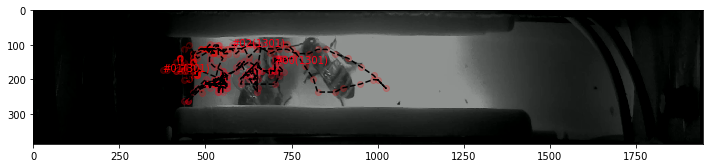

Detection/track statistics:


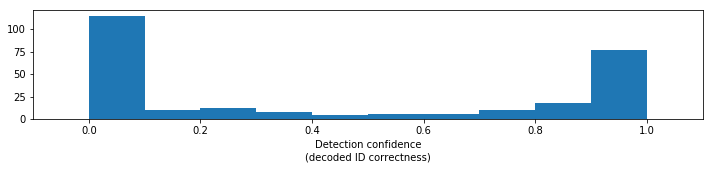

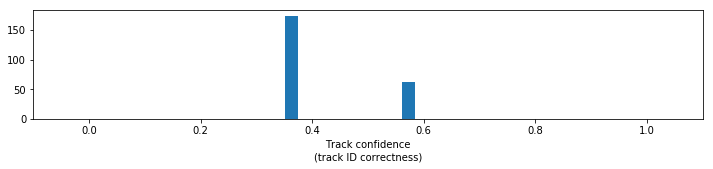

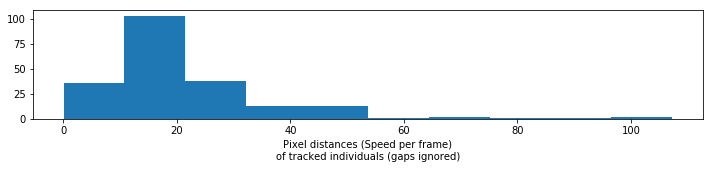

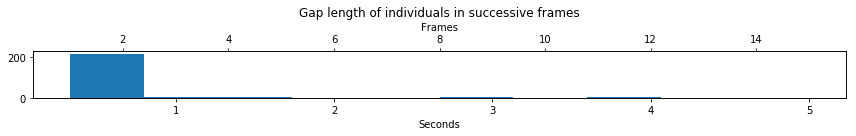

Individual statistics:


ModuleNotFoundError: No module named 'cairocffi'

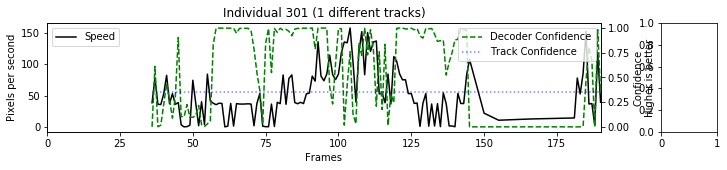

In [13]:
#video_data["file"][0] --> frame-info, [1] --> detections, [2] --> tracks
for path in paths:
    display_tracking_results(path, video_data[path][0], video_data[path][1], video_data[path][2])

type(video_data[paths[0]][2])

# Save detection to .csv

In [ ]:
detections

# Algorithmus: Baseline

In [22]:
""" Vorgehen:
Für jedes Video
- Prüfe, wo sich die Biene beim ersten erkannten Erscheinen aufhält
    - Ordne die Position in left, right oder middle ein
- Prüfe, wo sich die Biene beim letzten erkannten Erscheinen aufhält
    - Ordne die Position in left, right oder middle ein
Daraus kann nun abgeleitet werden, wo die Biene reingekommen ist und wo sie rausgegangen ist
"""
import pandas as pd
from enum import Enum
class Side(Enum):
    LEFT = -1
    MIDDLE = 0
    RIGHT = 1
    
bee_moves = {"video":[], "bee_id":[], "in_direction":[], "out_direction":[]}

for i in range(len(paths)):
    # Konvention: Jede bee_id hat eine zugehörige Liste der Form
    # "bee_id" : [(x_start, y_start),(x_bisher_letzter, y_bisher_letzter)]
    movement = dict()

    # Finde start- und endposition
    for row in video_data[paths[i]][2].itertuples():
        bee_id = row[13]
        xpos = row[4]
        ypos = row[5]
        timestamp = row[8]

        if bee_id in movement.keys():
            if not movement[bee_id]: #hier wird value betrachtet
                movement[bee_id] = [(xpos, ypos), None]
            else:
                movement[bee_id][1] = (xpos, ypos)
        else:
            movement[bee_id] = [(xpos, ypos), None]

    def is_left(xpos):
        return xpos <= config["left_leaving_area"]*config["px_x_resolution_vid"]
    def is_right(xpos):
        return xpos >= config["px_x_resolution_vid"] - config["right_leaving_area"]*config["px_x_resolution_vid"]

    # Setze labels, entferne andere Daten
    for bee_id in movement.keys():
        start_pos = movement[bee_id][0]
        end_pos = movement[bee_id][1]
        labels = dict()

        # Eintrittsseite festlegen
        if is_left(start_pos[0]):
            labels["in_direction"] = Side.LEFT
        elif is_right(start_pos[0]):
            labels["in_direction"] = Side.RIGHT
        else:
            labels["in_direction"] = Side.MIDDLE

        # Austrittsseite festlegen
        if is_left(end_pos[0]):
            labels["out_direction"] = Side.LEFT
        elif is_right(start_pos[0]):
            labels["out_direction"] = Side.RIGHT
        else:
            labels["out_direction"] = Side.MIDDLE
        
        video = path.split("/") # getting filename
        bee_moves["video"].append(video[2])
        bee_moves["bee_id"].append(bee_id)
        bee_moves["in_direction"].append(labels["in_direction"])
        bee_moves["out_direction"].append(labels["out_direction"])

results = pd.DataFrame(data=bee_moves)

In [23]:
# Ausgeben
results

,video,bee_id,in_direction,out_direction
0,e00_2018-08-19-17-01-12.h264,1301,Side.MIDDLE,Side.LEFT
1,e00_2018-08-19-17-01-12.h264,301,Side.LEFT,Side.LEFT
2,e00_2018-08-19-17-01-12.h264,1970,Side.MIDDLE,Side.LEFT


#Compare results with manually Data

In [15]:
# compare GroundTruthData with our results
import csv
# user to Dictionary to store datas we want to compare
dicManually = {}
dicAutomated = {}

# open and fetch GroundTruthData
with open("GroundTruthData.csv", "r") as testFile:
    reader = csv.DictReader(testFile)
    for row in reader:
        # check if bee has been detected manually
        if (row['bee_id'] != ""):
            # take video and store in dicManual
            if not (row['video'] in dicManually):
                dicManually[row['video']] = [[row['bee_id'], row['in_direction'], row['out_direction']]]
            else:
                #add to value List
                dicManually[row['video']].append([row['bee_id'], row['in_direction'], row['out_direction']])
        else:
            continue
            
# adding values from automated csv result-list

#to get header information
for index, column_header in enumerate(header_row):
    print(index, column_header)

In [16]:
#
output = {"video":[], "bee":[]}
if (bee_moves["video"][0] in dicManually):
    output["video"].append(bee_moves["video"][0])
    output["bee"].append(dicManually[bee_moves["video"][0]])
    
    resultManually = pd.DataFrame(data=output)

In [17]:
# print video-match
resultManually

,video,bee
0,e00_2018-08-19-17-01-12.h264,"[[1301, middle, left], [301, left, left]]"


In [18]:
#print result to csv
def insertCSV(video, bee, mboolean):
    attache = 'a'
    if not (os.path.isfile('./result.csv')):
        attache = 'w'
        
    with open('result.csv', attache) as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow([bee_moves['video'], bee_moves['bee_id'], mboolean])
        

In [19]:
# check matches of bees and give back a matching percent
_correctMatches = 0
_allMatches = 0

for bee in bee_moves['bee_id']: # get automated detected bee
    #print(bee)
    #print(dicManually[x])
    for beeManually in dicManually[bee_moves["video"][0]]: # get bees out of csv with matching video
        if (str(beeManually[0]) == str(bee)):    # compare bees
            _allMatches += 1
            # compare move of matching bee
            # get in_direction of both lists and comapare and 
            # get out_direction of both lists and compare
            if (str(beeManually[1]) == str(bee_moves['in_direction'][0]).split('.')[1].lower()):
                _correctMatches += 1
                #print(_correctMatches, _allMatches)
                insertCSV(bee_moves['video'], bee_moves['bee_id'],True)
            else:
                insertCSV(bee_moves['video'], bee_moves['bee_id'],False)
print(_correctMatches / _allMatches * 100, "% correct")

# problems:
# an manually tracked bee has more then one value than automated detected bee
# match manually detected bee with first and laste value??
            
            

50.0 % correct
